In [659]:
import pandapower as pp
import pandapower.networks as nw
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [660]:
net = nw.case30()

In [661]:
gen = net.gen
ext_grid = net.ext_grid

In [662]:
load_tot = net.load.p_mw.sum()

In [663]:
dis_load = [[0,30]]
disp_load = pd.DataFrame(dis_load, columns=['min_p','max_p'])

In [664]:
var_g = [[0,150]]
var_gen = pd.DataFrame(var_g, columns=['min_p','max_p'])
variatio = [[1],[0.9],[0.80],[0.7]]
var = pd.DataFrame(variatio, columns=['cap']) 

In [665]:
dem_data = [[load_tot],[load_tot+10],[load_tot+300],[load_tot+50]]
dem = pd.DataFrame(dem_data, columns=['Demand'])

In [666]:
gen_idx = gen.index
ext_grid_idx = ext_grid.index
disp_load_idx = disp_load.index
var_gen_idx = var_gen.index
dem_idx = dem.index
nTime = 4
#var_count = 1

In [667]:
#Storage
Cap = 100
SOC_ini = 0.3
SOC_exp = 0.5
eta_c = 0.98
eta_d = 0.95

In [668]:
pen_disp = 100
res_pen_fac = 0.2

In [669]:
model = gp.Model('ED_Look')
out_gen = model.addVars(gen_idx,nTime,vtype=GRB.CONTINUOUS, name="genout")
out_grid = model.addVars(ext_grid_idx,nTime,vtype=GRB.CONTINUOUS, name="gridout")
dis_l = model.addVars(disp_load_idx,nTime,vtype=GRB.CONTINUOUS, name="dispout")
out_var = model.addVars(var_gen_idx,nTime,vtype=GRB.CONTINUOUS, name="vargenout")
res_gvar = model.addVars(var_gen_idx,nTime,vtype=GRB.CONTINUOUS, name="resvargen")
res_displ = model.addVars(disp_load_idx,nTime,vtype=GRB.CONTINUOUS, name="resdisp")
#var_genout = model.addVars(var_count,nTime,vtype=GRB.CONTINUOUS, name="varout")
#flex_b = model.addVars(nTime, vtype=GRB.CONTINUOUS, name="flex_assignment")
SOC = model.addVars(nTime , vtype=GRB.CONTINUOUS , lb =0.2 , ub =0.9 , name ='SOC')
Pc = model.addVars(nTime , vtype=GRB.CONTINUOUS , lb =0, ub =60 , name ='Pc')
Pd = model.addVars(nTime , vtype=GRB.CONTINUOUS , lb =0, ub =60 , name ='Pd')
reserve_es = model.addVars(nTime,vtype=GRB.CONTINUOUS, name="reses")

In [670]:
a = np. array ([0.12 , 0.17 , 0.15 , 0.19, 0.21])
b = np. array ([14.8 , 16.57 , 15.55 , 16.21, 18.50])
c = np. array ([89 , 83, 100 , 70, 100])
a_gr = np. array ([0.2])
b_gr = np. array ([12])
c_gr = np. array ([80])

In [671]:
min_gr = model.addConstrs((out_grid[gr, p] >= ext_grid.loc[gr,'min_p_mw'])
                              for gr in ext_grid_idx for p in range(nTime))

#Max Gen Limit
max_gr = model.addConstrs((out_grid[gr, p] <= ext_grid.loc[gr,'max_p_mw'])
                              for gr in ext_grid_idx for p in range(nTime))


min_g = model.addConstrs((out_gen[g, p] >= gen.loc[g,'min_p_mw'])
                              for g in gen_idx for p in range(nTime))

#Max Gen Limit
max_g = model.addConstrs((out_gen[g, p] <= gen.loc[g,'max_p_mw'])
                              for g in gen_idx for p in range(nTime))

min_dis = model.addConstrs((dis_l[dl, p] >= disp_load.loc[dl,'min_p'])
                              for dl in disp_load_idx for p in range(nTime))

#Max disp Limit
max_dis = model.addConstrs((dis_l[dl, p] <= disp_load.loc[dl,'max_p'])
                              for dl in disp_load_idx for p in range(nTime))

In [672]:
min_gvar = model.addConstrs((out_var[gvar, p] >= var_gen.loc[gvar,'min_p'])
                              for gvar in var_gen_idx for p in range(nTime))

#Max gvar Limit
max_gvar = model.addConstrs((out_var[gvar, p] <= var_gen.loc[gvar,'max_p']*var.loc[p,'cap'])
                              for gvar in var_gen_idx for p in range(nTime))

In [673]:
init_soc = model.addConstr(Cap *SOC [0] == Cap * SOC_ini +( Pc [0]* eta_c -Pd [0]/ eta_d ), name ='SOC_1')
soc_t = model.addConstrs(( Cap *SOC [p] == Cap *SOC [p -1]+( Pc[p]* eta_c -Pd[p]/ eta_d ) for p in range (1, nTime)), 'SOC')
final_soc = model.addConstr(Cap *SOC [3] == Cap * SOC_exp , name ='SOC_24')

In [674]:
meet_demand = model.addConstrs(gp.quicksum(out_gen[g, p] for g in gen_idx) + gp.quicksum(out_grid[gr, p] for gr in ext_grid_idx) + gp.quicksum(out_var[gvar, p] for gvar in var_gen_idx) + Pd[p] >= gp.quicksum(dis_l[dl, p] for dl in disp_load_idx) + dem.loc[p,'Demand'] + Pc[p] for p in range(nTime))

In [675]:
reserve_gvar = model.addConstrs(res_gvar[gvar,p] <= ((var_gen.loc[gvar,'max_p']*var.loc[p,'cap'])-out_var[gvar, p]) for gvar in var_gen_idx for p in range(nTime))

In [676]:
reserve_dispload = model.addConstrs(res_displ[dl,p] <= (disp_load.loc[dl,'max_p']-dis_l[dl, p]) for dl in disp_load_idx for p in range(nTime))

In [677]:
res_es = model.addConstrs(reserve_es[p] <= gp.quicksum(Pc[p] for p in range(nTime)) - Pd[p] for p in range(nTime))

In [678]:
tot_reserve = model.addConstrs(gp.quicksum(res_gvar[gvar,p] for gvar in var_gen_idx) + gp.quicksum(res_displ[dl,p] for dl in disp_load_idx) + gp.quicksum(reserve_es[p] for p in range(nTime))
                    >= 0.15*dem.loc[p,'Demand'] for p in range(nTime))

In [679]:
res_cost = res_pen_fac*(gp.quicksum(10*res_gvar[gvar,p]
                    for gvar in var_gen_idx for p in range(nTime)) + gp.quicksum(pen_disp*res_displ[dl,p]
                    for dl in disp_load_idx for p in range(nTime)))

In [680]:
g_cost = gp.quicksum(a[g]*out_gen[g, p]*out_gen[g, p]+b[g]*out_gen[g, p]+c[g] for p in range(nTime) for g in gen_idx)
gr_cost = gp.quicksum(a_gr[gr]*out_grid[gr, p]*out_grid[gr, p]+b_gr[gr]*out_grid[gr, p]+c_gr[gr] for p in range(nTime) for gr in ext_grid_idx)

In [681]:
disp_cost = gp.quicksum(pen_disp*(disp_load.loc[dl,'max_p']-dis_l[dl, p]) for dl in disp_load_idx for p in range(nTime))

In [682]:
var_cost = gp.quicksum(10*out_var[gvar, p] for gvar in var_gen_idx for p in range(nTime))

In [683]:
es_cost = gp.quicksum(50*reserve_es[p] for p in range(nTime))

In [684]:
model.setObjective(g_cost + gr_cost + disp_cost+var_cost + res_cost + es_cost)
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 89 rows, 56 columns and 184 nonzeros
Model fingerprint: 0xf96d1ae7
Model has 24 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 1e+02]
  QObjective range [2e-01, 4e-01]
  Bounds range     [2e-01, 6e+01]
  RHS range        [3e+01, 5e+02]
Presolve removed 66 rows and 2 columns
Presolve time: 0.03s
Presolved: 23 rows, 54 columns, 116 nonzeros
Presolved model has 24 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.200e+01
 Factor NZ  : 2.120e+02
 Factor Ops : 2.340e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.71521180e+06 -7.01868753e+06  1.23e+03 8.82e+02  8.88e+05     0s
   1   1.66781520e+05 -1.50

In [685]:
v = model.getVars()
v

[<gurobi.Var genout[0,0] (value 29.13469155079294)>,
 <gurobi.Var genout[0,1] (value 29.134691567341743)>,
 <gurobi.Var genout[0,2] (value 79.99999999991306)>,
 <gurobi.Var genout[0,3] (value 46.66084381748668)>,
 <gurobi.Var genout[1,0] (value 15.359782271111717)>,
 <gurobi.Var genout[1,1] (value 15.35978228332771)>,
 <gurobi.Var genout[1,2] (value 49.99999999991393)>,
 <gurobi.Var genout[1,3] (value 27.731183871221983)>,
 <gurobi.Var genout[2,0] (value 20.80775324051318)>,
 <gurobi.Var genout[2,1] (value 20.807753254066018)>,
 <gurobi.Var genout[2,2] (value 54.99999999991694)>,
 <gurobi.Var genout[2,3] (value 34.8286750539244)>,
 <gurobi.Var genout[3,0] (value 14.690331505082954)>,
 <gurobi.Var genout[3,1] (value 14.690331516602956)>,
 <gurobi.Var genout[3,2] (value 29.999999999924658)>,
 <gurobi.Var genout[3,3] (value 25.759480287215986)>,
 <gurobi.Var genout[4,0] (value 7.838871362518709)>,
 <gurobi.Var genout[4,1] (value 7.838871374106688)>,
 <gurobi.Var genout[4,2] (value 39.9999

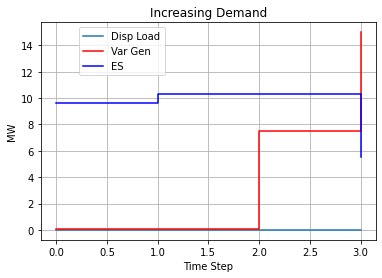

In [686]:
import matplotlib.pyplot as plt
var_flex = pd.DataFrame([0.1,0.1,7.5,15],columns=['Var Gen'])
es_flex = pd.DataFrame([9.6,10.3,10.3,5.5],columns=['ES'])
disp_flex = pd.DataFrame([0.01,0.02,0.01,0],columns=['Disp Load'])
ax = disp_flex.plot(label="Disp Load", drawstyle="steps-post")
var_flex.plot(ax = ax, label="Var Gen", drawstyle="steps-post", color = 'r')
es_flex.plot(ax = ax, label="ES", drawstyle="steps-post", color = 'b')
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.title("Increasing Demand")
plt.legend(loc = 'upper left',bbox_to_anchor=(0.1, 0.5, 0.5, 0.5))
plt.grid()
plt.show()
#dem_data = [[load_tot],[load_tot+50],[load_tot+100],[load_tot+150]]

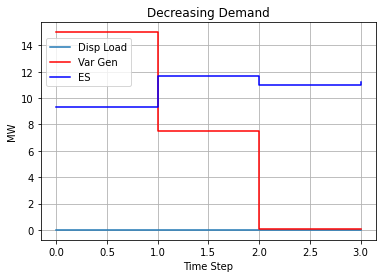

In [687]:
import matplotlib.pyplot as plt
var_flex = pd.DataFrame([15,7.5,0.1,0.1],columns=['Var Gen'])
es_flex = pd.DataFrame([9.3,11.7,11,11.2],columns=['ES'])
disp_flex = pd.DataFrame([0.01,0.02,0.01,0],columns=['Disp Load'])
ax = disp_flex.plot(label="Disp Load", drawstyle="steps-post")
var_flex.plot(ax = ax, label="Var Gen", drawstyle="steps-post", color = 'r')
es_flex.plot(ax = ax, label="ES", drawstyle="steps-post", color = 'b')
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.title("Decreasing Demand")
plt.legend(loc = 'upper left',bbox_to_anchor=(0., 0.45, 0.5, 0.5))
plt.grid()
plt.show()
#dem_data = [[load_tot+200],[load_tot+150],[load_tot+100],[load_tot+50]]

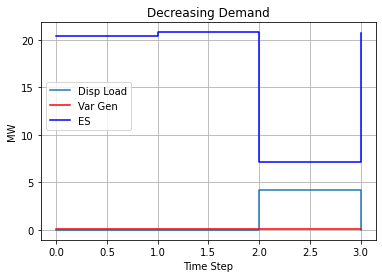

In [658]:
import matplotlib.pyplot as plt
var_flex = pd.DataFrame([0.1,0.1,0.1,0.1],columns=['Var Gen'])
es_flex = pd.DataFrame([20.4,20.8,7.11,20.68],columns=['ES'])
disp_flex = pd.DataFrame([0.01,0.02,4.2,0],columns=['Disp Load'])
ax = disp_flex.plot(label="Disp Load", drawstyle="steps-post")
var_flex.plot(ax = ax, label="Var Gen", drawstyle="steps-post", color = 'r')
es_flex.plot(ax = ax, label="ES", drawstyle="steps-post", color = 'b')
plt.xlabel("Time Step")
plt.ylabel("MW")
plt.title("Decreasing Demand")
plt.legend(loc = 'upper left',bbox_to_anchor=(0., 0.25, 0.5, 0.5))
plt.grid()
plt.show()
#dem_data = [[load_tot],[load_tot+10],[load_tot+300],[load_tot+50]]